<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Eran2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%%bash

git clone https://github.com/eth-sri/ERAN.git

sudo apt install m4
sudo apt install build-essential
sudo apt install autoconf
sudo apt install libtool
sudo apt install texlive-latex-base

cd ERAN
sudo bash ./install.sh
pip install -r requirements.txt

In [2]:
%pip uninstall -y pillow
%pip install pillow

# Currently you have to do this and restart the runtime
# This needs to go by removing pillow from the requirements.txt before installing it or installing the packages manually

Found existing installation: Pillow 9.2.0
Uninstalling Pillow-9.2.0:
  Successfully uninstalled Pillow-9.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.2.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [49]:
%%capture

%pip install onnx onnxruntime

import torch
from torch import nn
import numpy as np
import torch.onnx
import sys

import matplotlib.pyplot as plt

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/iris_trainer.py'}
import iris_trainer

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/plots.py'}
import plots

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/zonotpy/main/src/zonotope.py'}
from zonotope import zono

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/zonotpy/main/src/interval_abstraction.py'}
import interval_abstraction as ia

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/zonotpy/main/src/nn_functions.py'}
import nn_functions as zf

Shape of X (data): (150, 4)
Shape of y (target): (150,) int64
Example of x and y pair: [5.1 3.5 1.4 0.2] 0
Shape of training set X (120, 4)
Shape of test set X (30, 4)


100%|██████████| 100/100 [00:00<00:00, 833.79it/s]


Done. Accuracy: 0.8


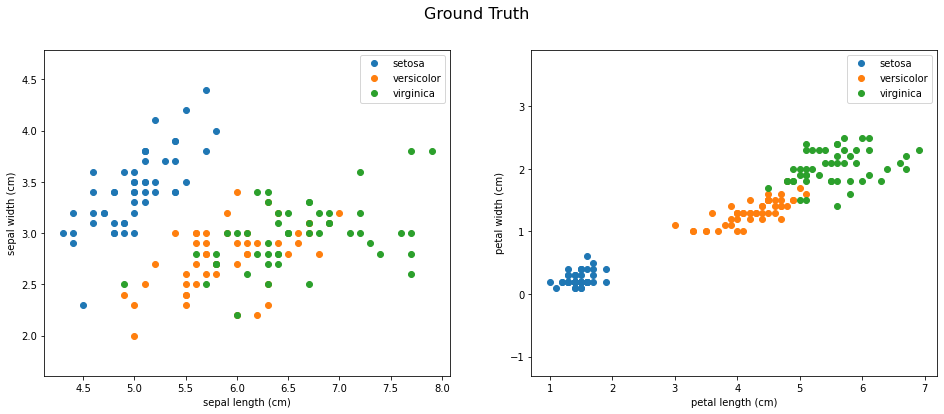

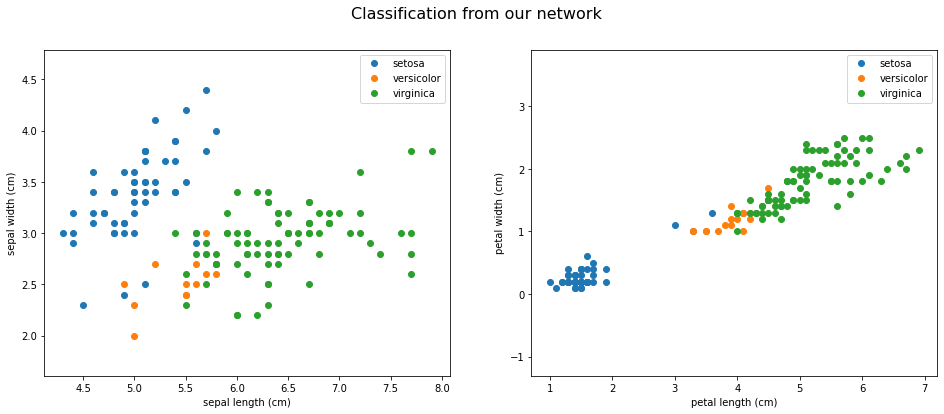

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

names, feature_names, X, y, X_scaled, X_train, X_test, y_train, y_test = iris_trainer.load_dataset()

model = iris_trainer.train_model(
    NeuralNetwork(input_dim=X_train.shape[1], output_dim=3, number_of_neurons=10), 
    epochs=100, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test)

plots.show_plots(names, feature_names, X, y, title = 'Ground Truth')
plots.show_plots(names, feature_names, X, iris_trainer.predict(X_scaled, model), title = 'Classification from our network')

In [34]:
print(X[0])
print(y[0])

[5.1 3.5 1.4 0.2]
0


In [20]:
model_parameters = [param.cpu().detach().numpy() for param in model.parameters()]
weights = model_parameters[0::2]
print(weights)
biases = model_parameters[1::2]
print(biases)

[array([[ 0.46685746,  0.32909364, -0.0282767 ,  0.54955614],
       [ 0.0172611 ,  0.02290974, -0.12281221,  0.41526493],
       [ 0.523001  , -0.478515  ,  0.5259937 ,  0.18491063],
       [ 0.2740115 ,  0.16081864,  0.14608881, -0.16564141],
       [ 0.28994012,  0.16899002, -0.3296092 ,  0.03140867],
       [-0.36010888,  0.08178136, -0.336214  ,  0.19957386],
       [-0.4992351 , -0.2792941 , -0.25612512, -0.41110736],
       [ 0.13729134, -0.4165266 ,  0.55389017, -0.32846192],
       [ 0.27337956,  0.18386434, -0.26979002,  0.19589926],
       [ 0.14065513,  0.34247053,  0.11684313, -0.09563331]],
      dtype=float32), array([[-4.0884161e-01, -1.7889611e-01, -3.3641985e-01,  1.9724481e-01,
         1.5924151e-01,  2.3257905e-01,  1.9868356e-01, -9.8084882e-02,
         1.9088311e-01, -1.5485901e-01],
       [-6.5957919e-02, -3.4132412e-01,  2.0124383e-01, -2.7870901e-02,
         1.7993769e-04, -1.6354296e-01,  1.4877616e-01, -9.6463762e-02,
        -2.3989472e-01, -2.6587668e-0

In [21]:
model_filename = "iris_net.onnx"
dummy_input=torch.randn(1, 4)

# set model to eval mode
model.eval()

# create a dummy input in the shape of the input values
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = dummy_input.to(device)

torch.onnx.export(model,
                  dummy_input,
                  model_filename,
                  export_params=True,
                  verbose=False,
                  input_names=['data'],
                  output_names=['classification'],
                  )

In [52]:
%%writefile input_box.txt
[5.1, 5.11]
[3.5, 3.51]
[1.4, 1.41]
[0.2, 0.21]

Overwriting input_box.txt


In [64]:
%%writefile zonotype_example.txt
4
3
5.1 0.03 0.0
3.5 0.0 0.03
1.4 0.03 0.0 
0.2 0.0 0.03

Overwriting zonotype_example.txt


In [67]:
%%bash
cd ERAN/tf_verify/

python3 . --netname ../../iris_net.onnx --zonotope ../../zonotype_example.txt --input_box ../../input_box.txt --domain deepzono --debug true 

{'approx_k': True,
 'attack': False,
 'complete': False,
 'data_dir': None,
 'dataset': None,
 'debug': True,
 'delta': 0.3,
 'domain': 'deepzono',
 'epsfile': None,
 'epsilon': 0,
 'from_test': 0,
 'gamma': inf,
 'geometric': False,
 'geometric_config': None,
 'input_box': '../../input_box.txt',
 'k': 3,
 'logdir': None,
 'logname': None,
 'max_milp_neurons': 30,
 'mean': None,
 'n_milp_refine': 1,
 'netname': '../../iris_net.onnx',
 'normalized_region': True,
 'num_params': 0,
 'num_tests': None,
 'numproc': 2,
 'output_constraints': None,
 'partial_milp': 0,
 'quant_step': None,
 'refine_neurons': False,
 's': -2,
 'sparse_n': 70,
 'spatial': False,
 'specnumber': None,
 'std': None,
 'subset': None,
 't_norm': 'inf',
 'target': None,
 'timeout_complete': None,
 'timeout_final_lp': 100,
 'timeout_final_milp': 100,
 'timeout_lp': 1,
 'timeout_milp': 1,
 'use_default_heuristic': True,
 'use_milp': True,
 'vnn_lib_spec': None,
 'zonotope': '../../zonotype_example.txt'}
netname  ../../i

2022-07-13 09:21:38.983584: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
./optimizer.py:26: UserWarning: gpupoly not available.
  warnings.warn("gpupoly not available.")


In [63]:
def relu(x):
  if x > 0: return x
  return 0

input_nodes = [5.1, 3.5, 1.4, 0.2]

def calculate_point(input_node):
  hidden_nodes = []
  for i in range(10):
    z = 0
    for w in range(4):
      z = z + (input_nodes[w] * weights[0][i][w])
    hidden_nodes.append(z)

  for i in range(10):
    hidden_nodes[i] = hidden_nodes[i] + biases[0][i]


  for i in range(10):
    hidden_nodes[i] = relu(hidden_nodes[i])


  output_nodes = []
  for i in range(3):
    z = 0
    for w in range(10):
      z = z + (hidden_nodes[w] * weights[1][i][w])
    output_nodes.append(z)

  for i in range(3):
    output_nodes[i] = output_nodes[i] + biases[1][i]

  return output_nodes

[-1.404938534903796, -0.947693692162117, 1.7137603030554713]


[(5.0, 5.199999999999999), (3.4, 3.6), (1.2999999999999998, 1.5), (0.1, 0.30000000000000004)]
[(-1.4854501551016916, -1.3287805380283988), (-1.0037260930949883, -0.8960536438917288), (1.6249111724772785, 1.8046099578540924)]
[[-1.40711535 -0.05037377 -0.02796104  0.        ]
 [-0.94988987  0.01084902 -0.0429872   0.        ]
 [ 1.71476057  0.05414659  0.0357028   0.        ]]
-1.3287805380283988
-1.4854501551016916
-0.8960536438917288
-1.0037260930949883
1.8046099578540924
1.6249111724772785


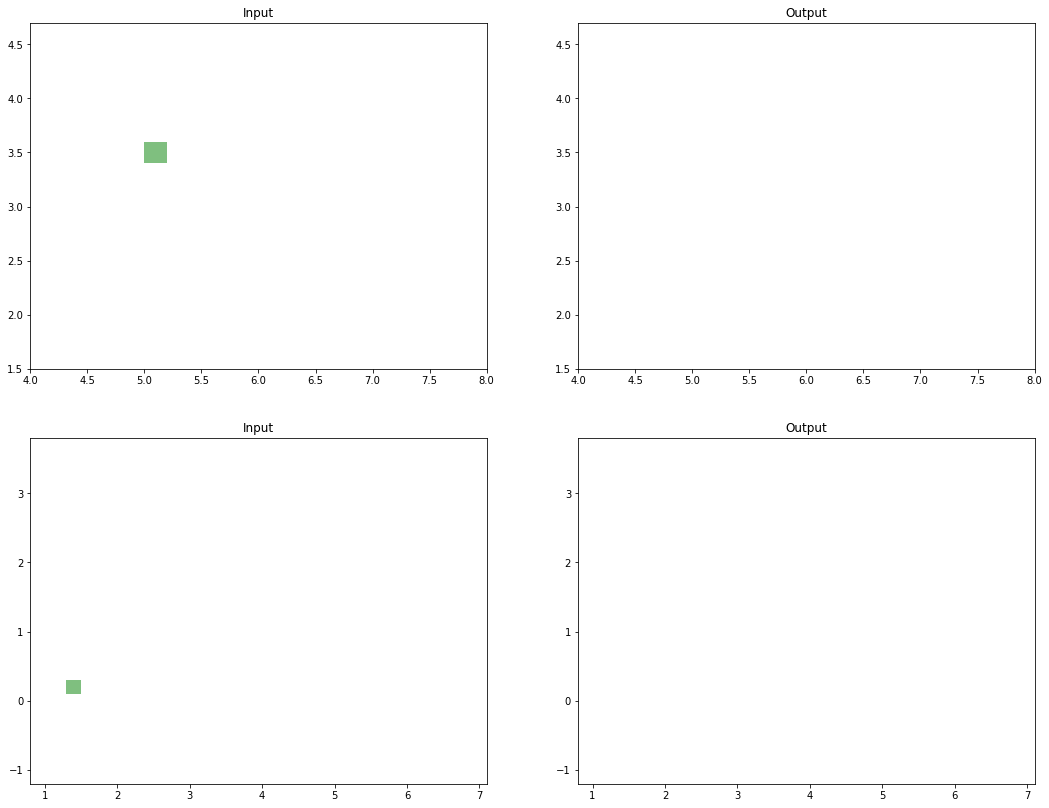

In [59]:
def create_plot():
  fig, ax = plt.subplots(2, 2)

  fig.set_size_inches(18, 14)

  ax[0][0].set_title("Input")
  ax[0][0].set_xlim(4, 8)
  ax[0][0].set_ylim(1.5, 4.7)
  ax[0][1].set_title("Output")
  ax[0][1].set_xlim(4, 8)
  ax[0][1].set_ylim(1.5, 4.7)

  ax[1][0].set_title("Input")
  ax[1][0].set_xlim(0.8, 7.1)
  ax[1][0].set_ylim(-1.2, 3.8)
  ax[1][1].set_title("Output")
  ax[1][1].set_xlim(0.8, 7.1)
  ax[1][1].set_ylim(-1.2, 3.8)
  return fig, ax

fig, ax = create_plot()

input = zono(values = np.array([[5.1, 0.1, 0], [3.5, 0, 0.1], [1.4, 0.1, 0], [0.2, 0, 0.1]]))
print(input.to_intervals())
k1, k2 = input.split()
i1, i2 = k1.split()
i3, i4 = k2.split()

input_nodes = [i1, i2, i3, i4]

k1.visualize(shape=True, fig=fig, ax=ax[0][0])
k2.visualize(shape=True, fig=fig, ax=ax[1][0])

hidden_nodes = []
for i in range(10):
  z = zono()
  for w in range(4):
    z = z + (input_nodes[w] * weights[0][i][w])
  hidden_nodes.append(z)

for i in range(10):
  hidden_nodes[i] = hidden_nodes[i] + zono(values = np.array([[biases[0][i]]]))


for i in range(10):
  hidden_nodes[i] = zf.relu(hidden_nodes[i])


output_nodes = []
for i in range(3):
  z = zono()
  for w in range(10):
    z = z + (hidden_nodes[w] * weights[1][i][w])
  output_nodes.append(z)

for i in range(3):
  output_nodes[i] = output_nodes[i] + zono(values = np.array([[biases[1][i]]]))

output = output_nodes[0].combine(output_nodes[1]).combine(output_nodes[2])

print(output.to_intervals())
print(output)

print(output.upper_bound(1))
print(output.lower_bound(1))

print(output.upper_bound(2))
print(output.lower_bound(2))

print(output.upper_bound(3))
print(output.lower_bound(3))

plt.show()